In [2]:
# import things
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.models import load_model
from skimage.morphology import skeletonize
from skan import Skeleton, summarize


In [24]:
def analyze_primary_root(mask):
    """
    Skeletonize the root mask and extract the primary root details.

    Parameters:
        mask (numpy array): Binary mask of the root.

    Returns:
        dict: Primary root details (length).
        numpy array: Skeletonized mask.
    """
    from skan import Skeleton, summarize
    
    # Skeletonize the mask
    skeleton = skeletonize(mask > 0)

    # Extract RSA using Skan
    skeleton_obj = Skeleton(skeleton)
    skeleton_summary = summarize(skeleton_obj)

    # Identify the longest branch (primary root)
    longest_branch_idx = skeleton_summary['branch-distance'].idxmax()
    primary_length = skeleton_summary.loc[longest_branch_idx, 'branch-distance']

    # Collect primary root details (mock start coordinates for now)
    primary_root_details = {
        "length": primary_length,
        "start_coords": (0, 0),  # Replace with actual coordinates if needed
    }

    return primary_root_details, skeleton


In [25]:
def visualize_primary_roots(input_dir, results, output_path):
    """
    Create a visualization similar to Figure 7.2, showing primary root lengths.
    
    Parameters:
        input_dir (str): Directory containing the original root masks.
        results (list): List of primary root details for each mask.
        output_path (str): Filepath to save the combined visualization.
    """
    num_roots = len(results)
    fig, axes = plt.subplots(1, num_roots, figsize=(15, 5))
    
    for i, (root_result, ax) in enumerate(zip(results, axes)):
        # Load the original image
        mask_path = os.path.join(input_dir, root_result["filename"])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Overlay the skeleton
        overlay = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        start_coords = root_result['start_coords']
        
        # Draw red path (mocked for now; you would overlay actual coordinates of the primary root)
        cv2.line(overlay, start_coords, start_coords, color=(0, 0, 255), thickness=2)
        
        # Display in the subplot
        ax.imshow(overlay)
        ax.set_title(f"P{i}-{root_result['length']}px")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path)
    print(f"Visualization saved to {output_path}")


Visualization saved to ./primary_roots_visualization.png


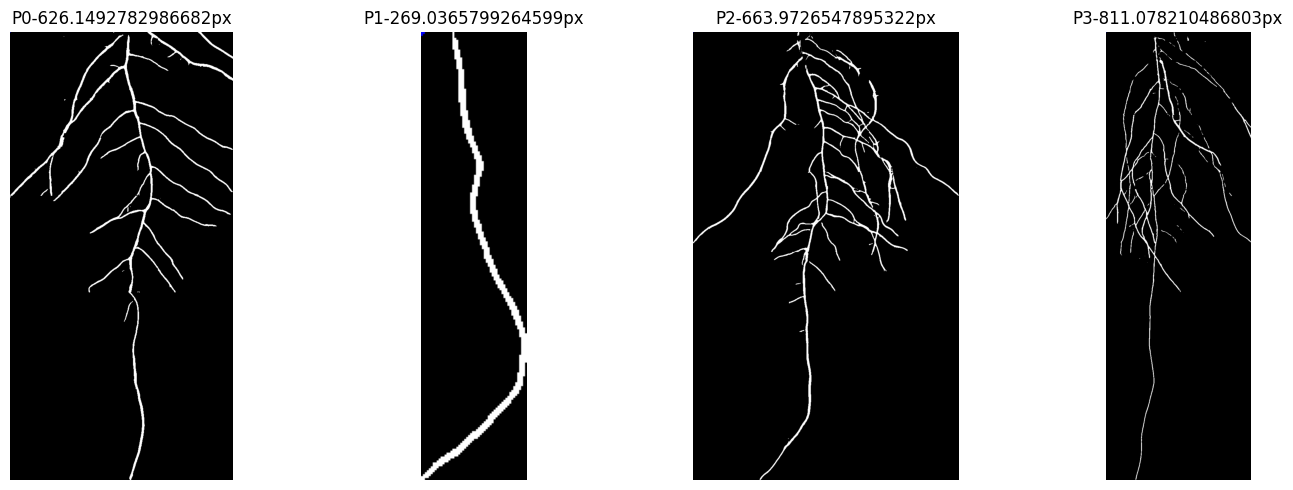

In [26]:
def batch_process_primary_roots(input_dir, output_dir, visualization_path):
    """
    Process all masks in the input directory to analyze primary roots and visualize results.
    
    Parameters:
        input_dir (str): Directory containing segmented root masks.
        output_dir (str): Directory to save analysis results.
        visualization_path (str): Path to save the combined visualization.
    """
    results = []
    for idx, filename in enumerate(sorted(os.listdir(input_dir))):
        if filename.endswith(".png") or filename.endswith(".tif"):
            mask_path = os.path.join(input_dir, filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Analyze the primary root
            primary_root_details, skeleton = analyze_primary_root(mask)
            primary_root_details['filename'] = filename
            results.append(primary_root_details)
    
    # Create the combined visualization
    visualize_primary_roots(input_dir, results, visualization_path)

# Define directories
input_directory = "./segmented_masks"  # Folder with root masks
output_directory = "./rsa_results"    # Where to save skeleton/RSA results
visualization_output = "./primary_roots_visualization.png"

# Run the batch processing
batch_process_primary_roots(input_directory, output_directory, visualization_output)


### Testing:

In [29]:
def analyze_primary_root_with_path(mask):
    """
    Skeletonize the root mask and extract the primary root details and path.

    Parameters:
        mask (numpy array): Binary mask of the root.

    Returns:
        dict: Primary root details (length and path coordinates).
        numpy array: Skeletonized mask.
    """
    from skimage.morphology import skeletonize
    from skan import Skeleton, summarize

    # Skeletonize the mask
    skeleton = skeletonize(mask > 0)

    # Extract RSA using Skan
    skeleton_obj = Skeleton(skeleton)
    skeleton_summary = summarize(skeleton_obj)

    # Identify the longest branch (primary root)
    longest_branch_idx = skeleton_summary['branch-distance'].idxmax()
    primary_length = skeleton_summary.loc[longest_branch_idx, 'branch-distance']

    # Extract coordinates for the primary root
    source_coord = (
        int(skeleton_summary.loc[longest_branch_idx, 'coord-src-0']),
        int(skeleton_summary.loc[longest_branch_idx, 'coord-src-1'])
    )
    dest_coord = (
        int(skeleton_summary.loc[longest_branch_idx, 'coord-dst-0']),
        int(skeleton_summary.loc[longest_branch_idx, 'coord-dst-1'])
    )

    # Collect primary root details
    primary_root_details = {
        "length": primary_length,
        "path": [source_coord, dest_coord],  # Start and end points
    }

    return primary_root_details, skeleton


In [30]:
def visualize_primary_roots_with_path(input_dir, results, output_path):
    """
    Create a visualization showing primary root lengths with red line overlays.

    Parameters:
        input_dir (str): Directory containing the original root masks.
        results (list): List of primary root details for each mask.
        output_path (str): Filepath to save the combined visualization.
    """
    import matplotlib.pyplot as plt
    import cv2
    import os

    num_roots = len(results)
    fig, axes = plt.subplots(1, num_roots, figsize=(15, 5))
    
    for i, (root_result, ax) in enumerate(zip(results, axes)):
        # Load the original mask
        mask_path = os.path.join(input_dir, root_result["filename"])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert the mask to RGB for overlay
        overlay = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

        # Draw the primary root path in red
        path = root_result['path']
        cv2.line(overlay, path[0][::-1], path[1][::-1], color=(0, 0, 255), thickness=2)
        
        # Display the image with overlay
        ax.imshow(overlay)
        ax.set_title(f"P{i}-{int(root_result['length'])}px")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path)
    print(f"Visualization saved to {output_path}")


Visualization saved to ./primary_roots_visualization.png


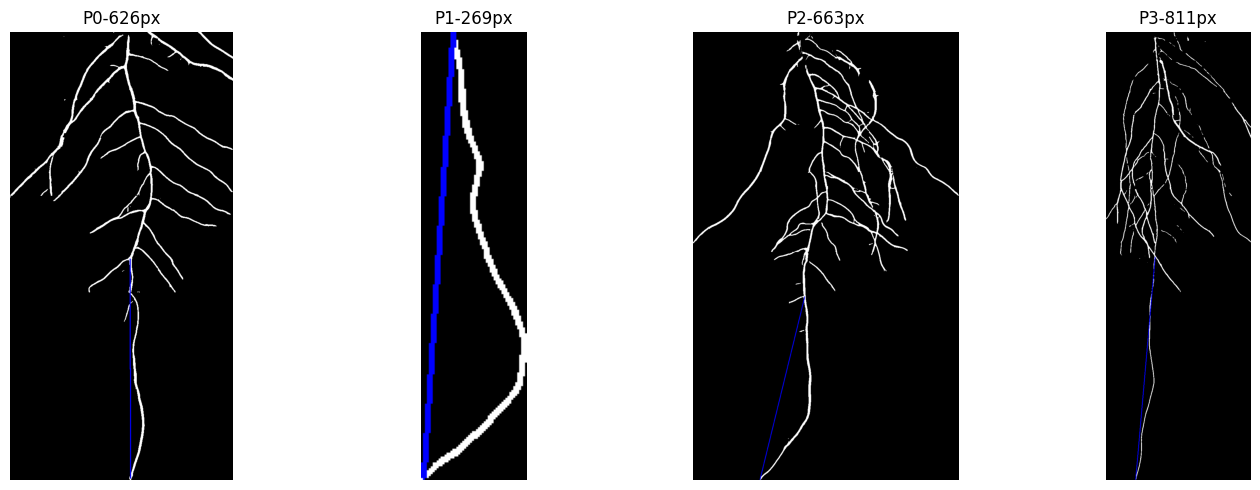

In [31]:
def batch_process_primary_roots_with_path(input_dir, output_dir, visualization_path):
    """
    Process all masks in the input directory, analyze primary roots, and create a visualization.

    Parameters:
        input_dir (str): Directory containing segmented root masks.
        output_dir (str): Directory to save analysis results.
        visualization_path (str): Path to save the combined visualization.
    """
    results = []
    for idx, filename in enumerate(sorted(os.listdir(input_dir))):
        if filename.endswith(".png") or filename.endswith(".tif"):
            mask_path = os.path.join(input_dir, filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Analyze the primary root and extract the path
            primary_root_details, skeleton = analyze_primary_root_with_path(mask)
            primary_root_details['filename'] = filename
            results.append(primary_root_details)
    
    # Create the combined visualization with red line overlay
    visualize_primary_roots_with_path(input_dir, results, visualization_path)

# Run the batch processing
batch_process_primary_roots_with_path(input_directory, output_directory, visualization_output)
